In [1]:
# Load libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
#plt.style.use('ggplot')
from matplotlib.ticker import FormatStrFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

import plotly.express as px
import plotly.graph_objects as go

import geopandas as gpd

import contextily as cx

import libpysal
from libpysal  import weights
from libpysal.weights import Queen

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

from giddy.directional import Rose

import statsmodels.api as sm
import statsmodels.formula.api as smf

from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error 

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

import warnings
warnings.filterwarnings('ignore') 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
df = pd.read_stata("../data/longPanel_N274T14_clubs.dta").fillna(value=0).sort_values(by=['year','finalclub_trend_ln_gdp'],ascending=[True,True])
df.head()

id                                             region  year  \
2436  175.0                                         Luxembourg  2003   
3556  255.0                                Inner London - West  2003   
28      3.0                                               Wien  2003   
84      7.0                                           Salzburg  2003   
126    10.0  Région de Bruxelles-Capitale / Brussels Hoofds...  2003   

      trend_ln_gdp nuts_id country  clubPS  highClub_n     ln_gdp  \
2436     10.917345    LU00      LU       0       999.0  10.837618   
3556     11.715281    UKI3      UK       0       999.0  11.675044   
28       10.556463    AT13      AT       1         1.0  10.526749   
84       10.365042    AT32      AT       1         1.0  10.325482   
126      10.894950    BE10      BE       1         1.0  10.864752   

      club_trend_ln_gdp  finalclub_trend_ln_gdp  re_trend_ln_gdp  
2436                0.0                     0.0         1.101696  
3556                0.0                     0.0         1.182218  
28                  1.0                     1.0         1.065279  
84                  1.0                     1.0         1.045962  
126                 1.0                     1.0         1.099436

In [3]:
df.columns

Index(['id', 'region', 'year', 'trend_ln_gdp', 'nuts_id', 'country', 'clubPS',
       'highClub_n', 'ln_gdp', 'club_trend_ln_gdp', 'finalclub_trend_ln_gdp',
       're_trend_ln_gdp'],
      dtype='object')

In [4]:
df.dtypes

id                        float32
region                     object
year                        int16
trend_ln_gdp              float32
nuts_id                    object
country                    object
clubPS                       int8
highClub_n                float32
ln_gdp                    float32
club_trend_ln_gdp         float32
finalclub_trend_ln_gdp    float32
re_trend_ln_gdp           float32
dtype: object

In [5]:
df[df['year']==2010].describe().round(2)

id    year  trend_ln_gdp  clubPS  highClub_n  ln_gdp  \
count  274.00   274.0        274.00  274.00      274.00  274.00   
mean   137.50  2010.0         10.05    3.25        7.81   10.04   
std     79.24     0.0          0.40    1.09       85.15    0.39   
min      1.00  2010.0          8.87    0.00        0.00    8.85   
25%     69.25  2010.0          9.84    3.00        0.00    9.84   
50%    137.50  2010.0         10.08    3.00        1.00   10.04   
75%    205.75  2010.0         10.28    4.00        1.00   10.27   
max    274.00  2010.0         11.91    5.00      999.00   11.89   

       club_trend_ln_gdp  finalclub_trend_ln_gdp  re_trend_ln_gdp  
count             274.00                  274.00           274.00  
mean                4.99                    3.25             1.00  
std                 2.03                    1.09             0.04  
min                 0.00                    0.00             0.88  
25%                 4.00                    3.00             0.98  
50%                 5.00                    3.00             1.00  
75%                 6.00                    4.00             1.02  
max                10.00                    5.00             1.19

In [6]:
df['id'] = df['id'].astype(str)
df["Club"]= df["finalclub_trend_ln_gdp"].astype(str)

In [7]:
df[df['year']==2016].describe().round(2)

year  trend_ln_gdp  clubPS  highClub_n  ln_gdp  club_trend_ln_gdp  \
count   274.0        274.00  274.00      274.00  274.00             274.00   
mean   2016.0         10.16    3.25        7.81   10.16               4.99   
std       0.0          0.38    1.09       85.15    0.38               2.03   
min    2016.0          9.06    0.00        0.00    9.06               0.00   
25%    2016.0          9.94    3.00        0.00    9.95               4.00   
50%    2016.0         10.16    3.00        1.00   10.17               5.00   
75%    2016.0         10.38    4.00        1.00   10.38               6.00   
max    2016.0         12.08    5.00      999.00   12.09              10.00   

       finalclub_trend_ln_gdp  re_trend_ln_gdp  
count                  274.00           274.00  
mean                     3.25             1.00  
std                      1.09             0.04  
min                      0.00             0.89  
25%                      3.00             0.98  
50%                      3.00             1.00  
75%                      4.00             1.02  
max                      5.00             1.19

## Long panel

In [8]:
px.strip(df, 
        x = 're_trend_ln_gdp', 
        hover_name= 'region', 
        color='Club',
        labels=dict(re_trend_ln_gdp="Relative Trend of log GDPpc",
                    Club="Convergence club"
                    ), 
        animation_frame= 'year')

In [9]:
px.violin(
    df[df['clubPS']!= 0],
    y="Club",
    x="re_trend_ln_gdp",
    color="Club",
    box=True,
    hover_name= 'region',
    labels=dict(re_trend_ln_gdp="Relative Trend of log GDPpc",
                    Club="Convergence club"
                    ), 
    animation_frame = 'year',
    points="all")

In [10]:
px.line(
    df,
    x="year",
    y="re_trend_ln_gdp",
    color="region",
    hover_name="Club",
    hover_data= ['country', 'region'],
    labels=dict(re_trend_ln_gdp="Relative Trend of log GDPpc",
                Club="Convergence club"
                )
    )

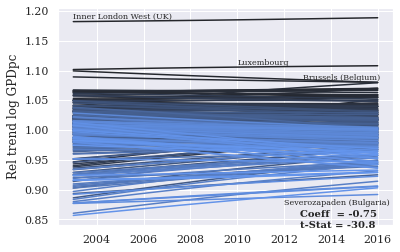

In [11]:
pal = sns.dark_palette('cornflowerblue', 274)
#pal = sns.dark_palette('seagreen', 274)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax = sns.lineplot('year', 're_trend_ln_gdp', ci=None, hue='region', data=df, palette=pal, legend = False)

plt.xlabel('')
plt.ylabel('Rel trend log GPDpc')

plt.text(2003, 1.187, "Inner London West (UK)", size = 8)
plt.text(2010, 1.11, "Luxembourg", size = 8)
plt.text(2012.8, 1.085, "Brussels (Belgium)", size = 8)
plt.text(2012, 0.875, "Severozapaden (Bulgaria)", size = 8)

plt.text(2012.7, 0.855, "Coeff  = -0.75", weight = 700)
plt.text(2012.7, 0.835, "t-Stat = -30.8", weight = 700)

plt.savefig('../results/relGDPpc.png',dpi=300, bbox_inches='tight')
plt.show()

In [12]:
df.columns

Index(['id', 'region', 'year', 'trend_ln_gdp', 'nuts_id', 'country', 'clubPS',
       'highClub_n', 'ln_gdp', 'club_trend_ln_gdp', 'finalclub_trend_ln_gdp',
       're_trend_ln_gdp', 'Club'],
      dtype='object')

In [13]:
fig = px.line(
    df[df['clubPS']!= 0],
    x="year",
    y="re_trend_ln_gdp",
    color="region",
    hover_name="Club",
    hover_data= ['country', 'region'],
    labels=dict(re_trend_ln_gdp="Relative Trend of log GDPpc",
                Club="Convergence club"
                ),
    facet_col="Club"
    )
fig.update_layout(showlegend=False)

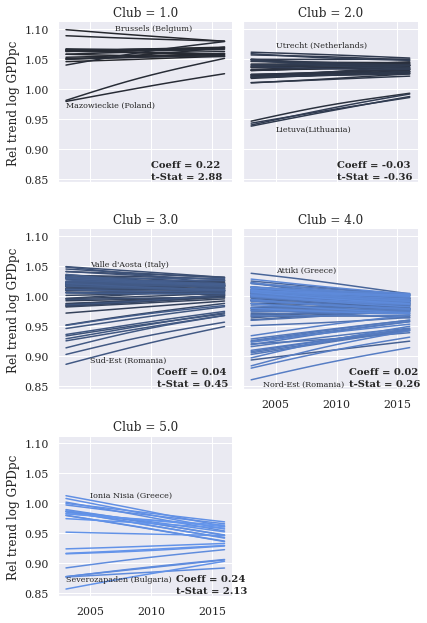

In [14]:
g = sns.FacetGrid(data= df[df['clubPS']!= 0], col='Club', col_wrap=2, hue='region', palette=pal)
g = g.map(sns.lineplot, 'year', 're_trend_ln_gdp', ci=None)

ax1 = g.axes[0]
ax2 = g.axes[1]
ax3 = g.axes[2]
ax4 = g.axes[3]
ax5 = g.axes[4]

ax1.text(2010, 0.87, "Coeff = 0.22", weight = 700)
ax1.text(2010, 0.85, "t-Stat = 2.88", weight = 700)
ax1.text(2007, 1.098, "Brussels (Belgium)", size = 8)
ax1.text(2003, 0.97, "Mazowieckie (Poland)", size = 8)
ax2.text(2010, 0.87, "Coeff = -0.03", weight = 700)
ax2.text(2010, 0.85, "t-Stat = -0.36", weight = 700)
ax2.text(2005, 1.07, "Utrecht (Netherlands)", size = 8)
ax2.text(2005, 0.93, "Lietuva(Lithuania)", size = 8)
ax3.text(2010.5, 0.87, "Coeff = 0.04", weight = 700)
ax3.text(2010.5, 0.85, "t-Stat = 0.45", weight = 700)
ax3.text(2005, 1.05, "Valle d'Aosta (Italy)", size = 8)
ax3.text(2005, 0.89, "Sud-Est (Romania)", size = 8)
ax4.text(2011, 0.87, "Coeff = 0.02", weight = 700)
ax4.text(2011, 0.85, "t-Stat = 0.26", weight = 700)
ax4.text(2005, 1.04, "Attiki (Greece)", size = 8)
ax4.text(2004, 0.85, "Nord-Est (Romania)", size = 8)
ax5.text(2012, 0.87, "Coeff = 0.24", weight = 700)
ax5.text(2012, 0.85, "t-Stat = 2.13", weight = 700)
ax5.text(2005, 1.01, "Ionia Nisia (Greece)", size = 8)
ax5.text(2003, 0.87, "Severozapaden (Bulgaria)", size = 8)

g.set_axis_labels('', 'Rel trend log GPDpc')
plt.savefig('../results/Clubs.png',dpi=300, bbox_inches='tight')
plt.show()

## Wide panel

In [15]:
gdf = gpd.read_file("../data/widePanel_N264T14.geojson")

In [16]:
gdf.head()

CNTR_CODE   FID  LEVL_CODE NUTS_ID         NUTS_NAME    COORD_X    COORD_Y  \
0        AT  AT11          2    AT11   Burgenland (AT)  16.533206  47.545241   
1        AT  AT12          2    AT12  Niederösterreich  15.740670  48.255405   
2        AT  AT13          2    AT13              Wien  16.399000  48.210333   
3        AT  AT21          2    AT21           Kärnten  13.886364  46.772185   
4        AT  AT22          2    AT22        Steiermark  14.965045  47.262140   

   id  g2003_2016 nuts_id_1            region  clubPS highClub country  \
0   1   -0.334141      AT11   Burgenland (AT)       3      yes      AT   
1   2   -0.327956      AT12  Niederösterreich       3      yes      AT   
2   3   -0.180980      AT13              Wien       1      yes      AT   
3   4   -0.330792      AT21           Kärnten       3      yes      AT   
4   5   -0.339507      AT22        Steiermark       2      yes      AT   

   ln_gdp2003  ln_gdp2004  ln_gdp2005  ln_gdp2006  ln_gdp2007  ln_gdp2008  \
0    9.820106    9.883285    9.893437    9.918376    9.961757    9.952278   
1    9.994242   10.060492   10.085809   10.134600   10.184900   10.196157   
2   10.526749   10.553205   10.584056   10.626194   10.647803   10.652542   
3   10.030120   10.081634   10.130623   10.173514   10.229188   10.229188   
4   10.064755   10.126631   10.169690   10.214642   10.268130   10.271597   

   ln_gdp2009  ln_gdp2010  ln_gdp2011  ln_gdp2012  ln_gdp2013  ln_gdp2014  \
0    9.928180    9.971147   10.012341   10.081634   10.094108   10.114558   
1   10.142505   10.173514   10.214642   10.261162   10.264652   10.288750   
2   10.616437   10.643041   10.666627   10.694215   10.685103   10.689670   
3   10.169690   10.203592   10.261162   10.298903   10.298903   10.325482   
4   10.218298   10.250617   10.298903   10.354563   10.354563   10.382822   

   ln_gdp2015  ln_gdp2016    sm2003    sm2004    sm2005    sm2006    sm2007  \
0   10.173514   10.154246  0.141343  0.139184  0.133157  0.132635  0.135112   
1   10.338511   10.322198  0.169624  0.166967  0.163442  0.160076  0.162563   
2   10.727663   10.707728  0.082121  0.077912  0.076258  0.072835  0.072063   
3   10.367222   10.360912  0.152106  0.152326  0.147171  0.147325  0.148258   
4   10.419301   10.404263  0.186888  0.184111  0.181726  0.180898  0.180749   

     sm2008    sm2009    sm2010    sm2011    sm2012    sm2013    sm2014  \
0  0.133617  0.128096  0.126280  0.128099  0.128794  0.129058  0.127796   
1  0.159139  0.154446  0.150000  0.149422  0.149268  0.148042  0.146070   
2  0.070048  0.067395  0.064980  0.062380  0.060175  0.058981  0.057247   
3  0.146759  0.139147  0.136296  0.138990  0.141603  0.137262  0.134811   
4  0.177223  0.170652  0.165126  0.165024  0.167591  0.164637  0.164102   

     sm2015 sm2016   ssk2003   ssk2004   ssk2005   ssk2006   ssk2007  \
0  0.125198   None  0.065371  0.068262  0.067901  0.069808  0.070568   
1  0.145699   None  0.081955  0.086259  0.087675  0.093732  0.095032   
2  0.055723   None  0.193891  0.197854  0.199845  0.203981  0.209742   
3  0.135420   None  0.085023  0.087209  0.089067  0.095328  0.098962   
4  0.164603   None  0.091084  0.096891  0.099355  0.104286  0.107025   

    ssk2008   ssk2009   ssk2010   ssk2011   ssk2012   ssk2013   ssk2014  \
0  0.074043  0.075149  0.075939  0.077686  0.080394  0.081981  0.086262   
1  0.101168  0.101262  0.103683  0.105417  0.107567  0.109148  0.110027   
2  0.218769  0.218617  0.221880  0.226633  0.230555  0.233740  0.234584   
3  0.103059  0.101670  0.107037  0.108998  0.109038  0.109810  0.111919   
4  0.111453  0.108582  0.116464  0.121940  0.123238  0.127629  0.127513   

    ssk2015 ssk2016   ssr2003   ssr2004   ssr2005   ssr2006   ssr2007  \
0  0.087956    None  0.244700  0.244681  0.250441  0.253927  0.256454   
1  0.112366    None  0.281504  0.281428  0.283864  0.284856  0.282937   
2  0.233999    None  0.262922  0.262799  0.257371  0.254330  0.252008   
3  0.112486    None  0.270671  0.269380  0.26873

In [17]:
gdf['Convergence club'] = gdf['clubPS']
gdf['Region'] = gdf['region']
gdf['Country'] = gdf['country']

In [18]:
gdf.explore(
    column='Convergence club',
    tooltip=['Convergence club', 'Region', 'Country'],
    scheme='naturalbreaks',
    cmap='coolwarm_r',
    legend=True,
    tiles='CartoDB positron',
    style_kwds=dict(color="gray", weight=0.9),
    legend_kwds=dict(colorbar=False, labels=['Club 1 (High income)', 'Club 2', 'Club 3', 'Club 4', 'Club 5 (Low income)'])
)


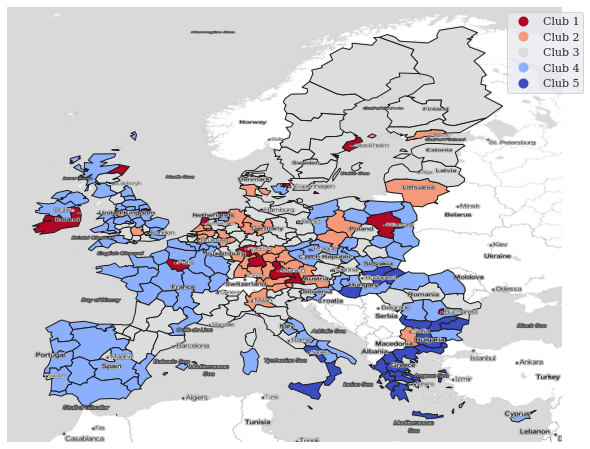

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(column='clubPS', edgecolor='k', scheme='NaturalBreaks', k=5, cmap='coolwarm_r', legend=True, legend_kwds={'bbox_to_anchor':(1.05, 1.00), 'labels':['Club 1', 'Club 2', 'Club 3', 'Club 4', 'Club 5']}, ax=ax)

cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite, attribution=False)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLabels, attribution=False)

ax.axis("off")

plt.savefig('../results/mapClubs.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
gdf.explore(
    column='re_y2016',
    tooltip=['clubPS', 'region', 're_y2016', 'country'],
    scheme='FisherJenks',
    cmap='coolwarm',
    legend=True,
    tiles='CartoDB positron',
    #width = 600,
    #height = 400,
    style_kwds =dict(color="gray", weight=0.9),
    legend_kwds=dict(colorbar=False)
)

(-12.725, 36.841, 32.87970000000001, 71.78229999999999)

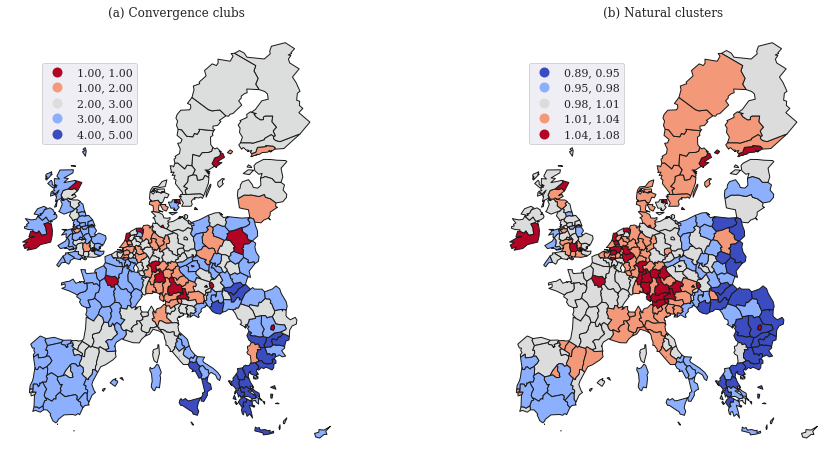

In [21]:
f,ax = plt.subplots(1,2, figsize=(16, 8))
gdf.plot(column='clubPS', ax=ax[0], edgecolor='k',
        scheme='NaturalBreaks', k=5, cmap='coolwarm_r', legend=True, legend_kwds={'bbox_to_anchor':(0.40, 0.92)})
ax[0].set_title("(a) Convergence clubs")
ax[0].axis("off")
gdf.plot(column='re_y2016', ax=ax[1], edgecolor='k',
        scheme='FisherJenks', k=5, cmap='coolwarm', legend=True, legend_kwds={'bbox_to_anchor':(0.40, 0.92)})
ax[1].set_title("(b) Natural clusters")
ax[1].axis("off")
#plt.savefig('../results/mapClubs.pdf',dpi=300, bbox_inches='tight');

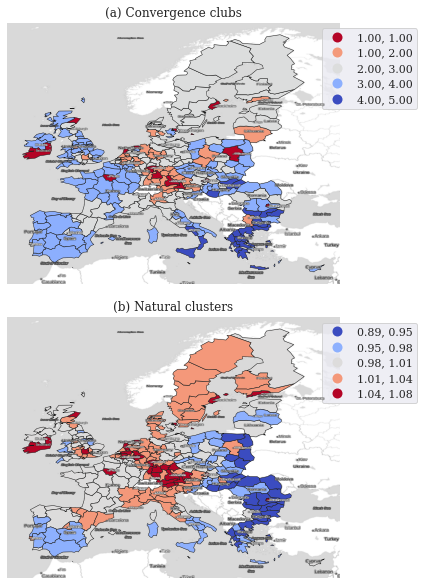

In [22]:
f,ax = plt.subplots(2,1, figsize=(6, 12) , gridspec_kw={'height_ratios': [1, 1]})
gdf.plot(column='clubPS', ax=ax[0], edgecolor='k', linewidth=0.5, alpha=1,
        scheme='NaturalBreaks', k=5, cmap='coolwarm_r', legend=True, legend_kwds={'bbox_to_anchor':(1.25, 1.00)})
cx.add_basemap(ax[0], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite, attribution=False)
cx.add_basemap(ax[0], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLabels, attribution=False)
ax[0].set_title("(a) Convergence clubs")
ax[0].axis("off")

plt.subplots_adjust(hspace=-0.8)

gdf.plot(column='re_y2016', ax=ax[1], edgecolor='k', linewidth=0.5, alpha=1,
        scheme='FisherJenks',   k=5, cmap='coolwarm',    legend=True, legend_kwds={'bbox_to_anchor':(1.25, 1.00)})
cx.add_basemap(ax[1], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite, attribution=False)
cx.add_basemap(ax[1], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLabels, attribution=False)
ax[1].set_title("(b) Natural clusters")
ax[1].axis("off")
plt.tight_layout()
plt.savefig('../results/mapClubsWithContext2.pdf',dpi=300, bbox_inches='tight');

In [23]:
#W = weights.Queen.from_dataframe(gdf) # There are 13 islands <<<<<<
#W = weights.Rook.from_dataframe(gdf)

#W = weights.KNN.from_dataframe(gdf, k=4)
W = weights.KNN.from_dataframe(gdf, k=5)
#W = weights.KNN.from_dataframe(gdf, k=6)
#W = weights.KNN.from_dataframe(gdf, k=8)

# Compute inverse distance squared based on maximum nearest neighbor distance between the n observations 
#maxMin = weights.min_threshold_dist_from_shapefile("map.shp")
#W = weights.DistanceBand.from_dataframe(gdf, threshold = maxMin, binary=False, alpha=-2)

# Row-standardize W
W.transform = 'r'

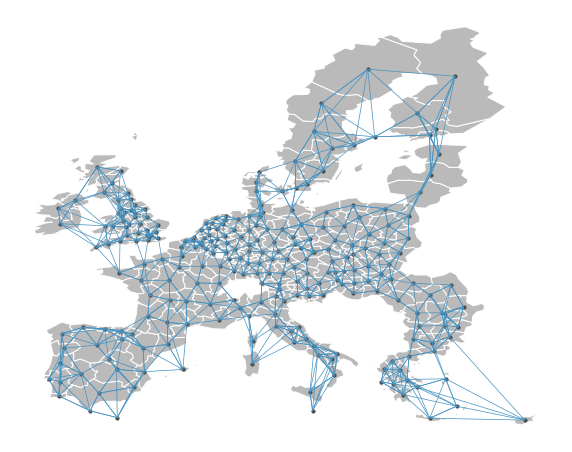

In [24]:
plot_spatial_weights(W, gdf);

In [25]:
moran2003 = Moran(gdf["re_y2003"], W)
moran2016 = Moran(gdf["re_y2016"], W)

In [26]:
print(moran2003.I, moran2016.I)

0.7061029401941813 0.5567258923685241


In [27]:
print(moran2003.p_sim, moran2016.p_sim)

0.001 0.001


In [28]:
Lmoran2003 = Moran_Local(gdf["re_y2003"], W, permutations = 999, seed=12345)
Lmoran2016 = Moran_Local(gdf["re_y2016"], W, permutations = 999, seed=12345)

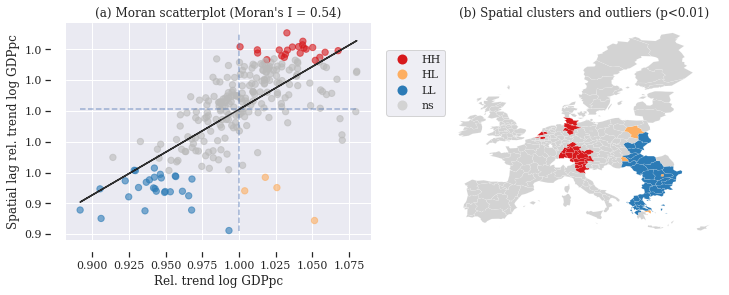

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
moran_scatterplot(Lmoran2016, p=0.01, aspect_equal=False, zstandard = False, ax=axes[0])
lisa_cluster(Lmoran2016, gdf, p=0.01, legend_kwds={'bbox_to_anchor':(0.02, 0.90)},  ax=axes[1])
axes[0].set_xlabel('Rel. trend log GDPpc')
axes[0].set_ylabel('Spatial lag rel. trend log GDPpc')
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[0].set_title("(a) Moran scatterplot (Moran's I = 0.54)")
axes[1].set_title("(b) Spatial clusters and outliers (p<0.01)")
plt.savefig('../results/lisaGDPrel.png',dpi=300, bbox_inches='tight')
plt.show()

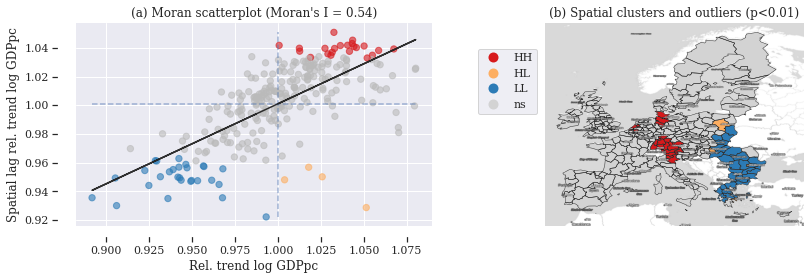

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

moran_scatterplot(Lmoran2016, p=0.01, aspect_equal=False, zstandard = False, ax=axes[0])

lisa_cluster(Lmoran2016, gdf, p=0.01, legend_kwds={'bbox_to_anchor':(-0.01, 0.90)},  ax=axes[1])

gdf.geometry.boundary.plot(color=None, edgecolor='k', linewidth=0.5, alpha=0.9, ax=axes[1])
cx.add_basemap(axes[1], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite, attribution=False)
cx.add_basemap(axes[1], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLabels, attribution=False)

axes[0].set_xlabel('Rel. trend log GDPpc')
axes[0].set_ylabel('Spatial lag rel. trend log GDPpc')
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[0].set_title("(a) Moran scatterplot (Moran's I = 0.54)")

axes[1].set_title("(b) Spatial clusters and outliers (p<0.01)")
plt.tight_layout()
plt.savefig('../results/lisaGDPrel.png',dpi=300, bbox_inches='tight')
plt.show()

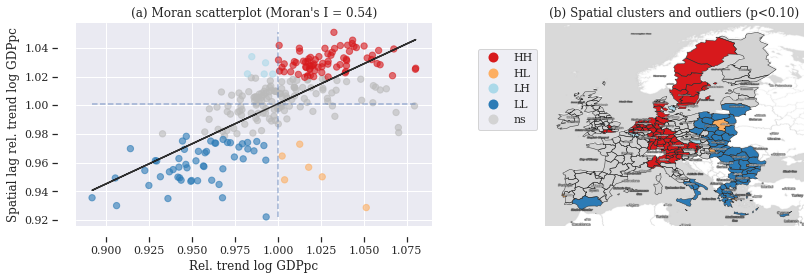

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

moran_scatterplot(Lmoran2016, p=0.10, aspect_equal=False, zstandard = False, ax=axes[0])

lisa_cluster(Lmoran2016, gdf, p=0.10, legend_kwds={'bbox_to_anchor':(-0.01, 0.90)},  ax=axes[1])

gdf.geometry.boundary.plot(color=None, edgecolor='k', linewidth=0.5, alpha=0.9, ax=axes[1])
cx.add_basemap(axes[1], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite, attribution=False)
cx.add_basemap(axes[1], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLabels, attribution=False)

axes[0].set_xlabel('Rel. trend log GDPpc')
axes[0].set_ylabel('Spatial lag rel. trend log GDPpc')
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[0].set_title("(a) Moran scatterplot (Moran's I = 0.54)")

axes[1].set_title("(b) Spatial clusters and outliers (p<0.10)")
plt.tight_layout()
#plt.savefig('../results/lisaGDPrel.png',dpi=300, bbox_inches='tight')
plt.show()

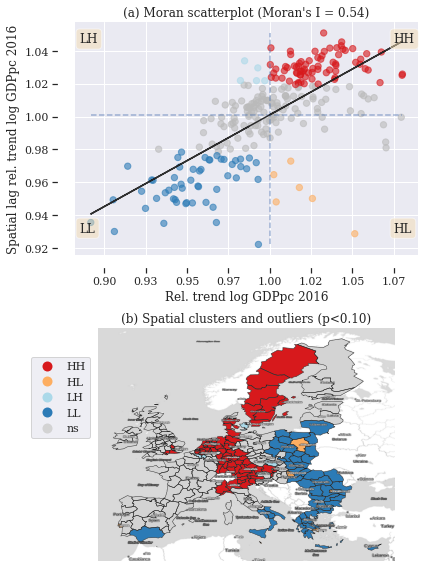

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,8), gridspec_kw={'height_ratios': [1, 1]}) 

moran_scatterplot(Lmoran2016, p=0.10, aspect_equal=False, zstandard = False, ax=axes[0])

#plt.subplots_adjust(hspace=0.1)

lisa_cluster(Lmoran2016, gdf, p=0.10, legend_kwds={'bbox_to_anchor':(-0.01, 0.90)},  ax=axes[1])

gdf.geometry.boundary.plot(color=None, edgecolor='k', linewidth=0.5, alpha=0.9, ax=axes[1])
cx.add_basemap(axes[1], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite, attribution=False)
cx.add_basemap(axes[1], crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLabels, attribution=False)

axes[0].set_xlabel('Rel. trend log GDPpc 2016')
axes[0].set_ylabel('Spatial lag rel. trend log GDPpc 2016')
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[0].set_title("(a) Moran scatterplot (Moran's I = 0.54)")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axes[0].text(0.885, 1.045, "LH", size = 12, bbox=props)
axes[0].text(0.885, 0.93,  "LL", size = 12, bbox=props)
axes[0].text(1.075,  1.045, "HH", size = 12, bbox=props)
axes[0].text(1.075, 0.93,   "HL", size = 12, bbox=props)

axes[1].set_title("(b) Spatial clusters and outliers (p<0.10)")
plt.tight_layout()
plt.savefig('../results/lisaGDPrel2.png',dpi=300, bbox_inches='tight')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=21b11231-f53f-47af-834c-e7b5347a5e33' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>